# Simulation with the Shyft API

## Introduction
In [Part I](run_nea_nidelva.ipynb) of the simulation tutorials, we covered conducting a very simple simulation of an example catchment using configuration files. This is a typical use case, but assumes that you have a model well configured and ready for simulation. In practice, one is likely to be interested in exploring different models, configurations, and data sources. Shyft provides a set of tools to conduct this type of analysis, known as the "multiple working model" hypothesis.

This is in fact a key idea of Shyft -- to make it simple to evaluate the impact of the selection of model routine (or forcing data) on the performance of the simulation. In this notebook we walk through a lower level paradigm of working with the toolbox and using the Shyft API directly to conduct the simulations.

### This notebook is guiding through the simulation process of a catchment. The following steps are described:
1. **Loading required python modules and setting path to SHyFT installation**
2. **Shyft initialization**
3. **Running a Shyft simulation with updated parameters**
4. **Activating the simulation only for selected catchments**
5. **Setting up different input datasets**
6. **Changing state collection settings**
7. **Post processing and extracting results**

## 1. Loading required python modules and setting path to SHyFT installation

Shyft requires a number of different modules to be loaded as part of the package. Below, we describe the required steps for loading the modules, and note that some steps are only required for the use of the jupyter notebook.

In [1]:
# Pure python modules and jupyter notebook functionality
# first you should import the third-party python modules which you'll use later on
# the first line enables that figures are shown inline, directly in the notebook
%matplotlib inline
import os
import datetime as dt
import pandas as pd
from netCDF4 import Dataset
from os import path
import sys
from matplotlib import pyplot as plt

### The Shyft Environment

This next step is highly specific on how and where you have installed Shyft. If you have followed the guidelines at github, and cloned the three shyft repositories: i) shyft, ii) shyft-data, and iii) shyft-doc, then you may need to tell jupyter notebooks where to find shyft. Uncomment the relevant lines below.

If you have a 'system' shyft, or used `conda install -s sigbjorn shyft` to install shyft, then you probably will want to make sure you have set the SHYFT_DATA directory correctly, as otherwise, Shyft will assume the above structure and fail. __This has to be done _before_ `import shyft`__. In that case, uncomment the relevant lines below.

**note**: it is most likely that you'll need to do one or the other.

In [2]:
# try to auto-configure the path, -will work in all cases where doc and data
# are checked out at same level
shyft_data_path = os.path.abspath("../../../../shyft-data")
if path.exists(shyft_data_path) and 'SHYFT_DATA' not in os.environ:
    os.environ['SHYFT_DATA']=shyft_data_path
    
# shyft should be available either by it's install in python
# or by PYTHONPATH set by user prior to starting notebook.
# This is equivalent to the two lines below
# shyft_path=path.abspath('../../../shyft')
# sys.path.insert(0,shyft_path)

In [3]:
# Shyft imports
import shyft.hydrology as api
import shyft.time_series as sts

## 2. Shyft initialization

In [Part I](run_nea_nidelva.ipynb) we used the `YAMLSimConfig` to read information regarding a preconfigured case. The configuration data for this case was stored in `.yaml` files. In this tutorial, we will walk through the process of using Shyft directly from the `shyft.api` and loading data from scratch. We will use the same dataset as an example. The data is stored in the [shyft-data](https://github.com/statkraft/shyft-data) repository, so you must be sure to have cloned that in a parallel directory to [shyft-doc](https://github.com/statkraft/shyft-doc).

We can review the [yaml configuration files](run_nea_nidelva.ipynb#2.-Configuration-of-a-SHyFT-simulation) from first tutorial. In particular, let's start by looking at the [datasets_config_file](nea-config/neanidelva_datasets.yaml) which points to our data. Let's just look at a part of this file under the `sources` stanza:

    sources:
    - repository: !!python/name:shyft.repository.netcdf.cf_geo_ts_repository.CFDataRepository
      types:
        - precipitation
      params:
        stations_met: ../shyft-data/netcdf/orchestration-testdata/precipitation.nc
        selection_criteria: null
        
As described earlier, [yaml configuration files](run_nea_nidelva.ipynb#2.-Configuration-of-a-SHyFT-simulation) provide a great deal of flexibility to configure runs, and save information. This particular example is showing one repository within the file for the `type` "precipitation". In this tutorial, we're simply interested in the path for the data. Looking at the file you'll see all data sets are stored within:

    ../shyft-data/netcdf/orchestration-testdata/

Recall that we have either set above, or from installation, have a `SHYFT_DATA` environment variable. This is still where our data is stored for this example. Next we can use this variable and read in the actually precipitation data using a pure (netCDF4) python approach. **Note** *we continue to work with the example netcdf files, but one could easily use their own data here as well*

### Repositories
To use Shyft efficiently, one should familiarize themselves with the concept of [repositories](repositories.rst). Briefly, here, we'll borrow some of the functions in our example repository used to read the netcdf data. Hopefully, between the examples here, and the information provided in the [repositories](repositories.rst) section, you'll gain enough understanding to start to write *your own* respositories for *your* data.

Again, refering to the `sources` stanza above, note that the first key is in fact `repository` and directs a user to the class that is used to read the data: `CFDataRepository`. This repository provides more functionality than is required for the example here, for example, for sub-setting data. However, once you have completed this tutorial it is a good idea to take a look at the `CFDataRepository` to gain an understanding of how they work.

But first, let's read that precipitation data...

In [4]:

# now let's read the 'precipitation.nc' file into our workspace using a netCDF4 Dataset
data_directory = os.path.join(os.environ['SHYFT_DATA'], 'netcdf/orchestration-testdata/')
precipitation = Dataset(os.path.join(data_directory, 'precipitation.nc'))

# explore the prec object to see what variables it contains.
print(precipitation)


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): time(8760), station(10)
    variables(dimensions): float64 time(time), <class 'str'> series_name(station), float64 x(station), float64 y(station), float64 z(station), int32 crs(), float64 precipitation(time, station)
    groups: 


The way we have structured the example datasets is to have a single netcdf file for each variable (e.g. precipitation, temperature, etc.) and a collection of stations within each file. The file has dimensions of `time` and `station`, where station is a unique id. The variables are `time`, `series_name`, `x`, `y`, `z` to give coordinates of the station. In addition we use a `crs` which is a code used to identify the coordinate system used. This is the approach of the example, you may use whatever works for you to keep your geolocation data coordinated. Lastly, the variable `precipitation` contains the precipitation data.

### Creating a Shyft source

In Shyft we have the concept of a `source`. The idea is that a `source` provides data to the simulation. Every cell in the `region` contains an `env_ts` attribute, which is a collection of the forcing time series. Currently, environmental time series include:

    precipitation
    temperature
    rel_hum
    radiation
    wind_speed
    
These are the forcing variables required for simulation using the existing algorithms, and for each one there is a Shyft `source` type. The cells get populated with these forcing data through an interpolation step. This is true both for point time series data or gridded forcing data. In the latter case, the interpolation treats each grid cell as a 'station'. Improvements to this approach are on the development roadmap.

We now need to take our time series data read in from the netcdf file, and create `api.PrecipitationSource` which also requires that we convert our raw numpy time series into `api.TimeSeries`. The following steps may seem complex, and some may wonder why not work with plain numpy. The reason is for efficiency. Shyft is optimized using specialized data types. We use the `api.TimeSeries` in order to assure robust and efficient underlying calculations.

We will work through a full example for precipitation, and then rely on a repository to load the rest of our data.

In [5]:
# prec contains all the precipitation forcing data we'll use:
x = precipitation.variables['x']
y = precipitation.variables['y']
z = precipitation.variables['z']
crs = precipitation.variables['crs']
time = precipitation.variables['time']
prec = precipitation.variables['precipitation']
names = precipitation.variables['series_name']
print(prec)
print(time)

<class 'netCDF4._netCDF4.Variable'>
float64 precipitation(time, station)
    coordinates: y x z
    units: mm
    grid_mapping: crs
unlimited dimensions: 
current shape = (8760, 10)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    units: seconds since 1970-01-01 00:00:00 +00:00
unlimited dimensions: 
current shape = (8760,)
filling on, default _FillValue of 9.969209968386869e+36 used


You can explore further all the individual variables, but take note that the `p` variable has all the metadata required for geolocation as well as units. Further it contains 10 stations with 8760 points. Also note that the `time` variable contains a units definition which we will use.


In [8]:
from netcdftime import utime
import numpy as np

""" These are the current supported regular time-step intervals """
delta_t_dic = {'days': sts.deltahours(24), 'hours': sts.deltahours(1), 'minutes': sts.deltaminutes(1),
               'seconds': sts.Calendar.SECOND}


def convert_netcdf_time(time_spec:str, t):
    """
    Converts supplied numpy array to  shyft utctime given netcdf time_spec.
    Throws exception if time-unit is not supported, i.e. not part of delta_t_dic
    as specified in this file.

    Parameters
    ----------
        time_spec: string
           from netcdef  like 'hours since 1970-01-01 00:00:00'
        t: numpy array
    Returns
    -------
        numpy array type int64 with new shyft utctime units (seconds since 1970utc)
    """
    u = utime(time_spec)
    t_origin = sts.Calendar(int(u.tzoffset)).time(u.origin.year, u.origin.month, u.origin.day, u.origin.hour, u.origin.minute, u.origin.second)
    #print (t[0],t_origin,delta_t_dic[u.units])
    delta_t = delta_t_dic[u.units]
    #return (t_origin + delta_t * t[:]).astype(np.int64)
    return t_origin + delta_t * t[:].astype(np.int64)

# note, the above could have simply been imported:
from shyft.hydrology.repository.netcdf.time_conversion import convert_netcdf_time as cnt



Note that in this example, the two values are the same. However, using shyft utctime we assure we keep track of the timezone. If your netcdf time.units attribute is different, Shyft will make the converstion into utctime.

### Look at the data
Before proceeding, we'll take a quick look at our precipitation data to assure it is as we expect.

In [20]:
nptime=time[:].astype(np.int64)

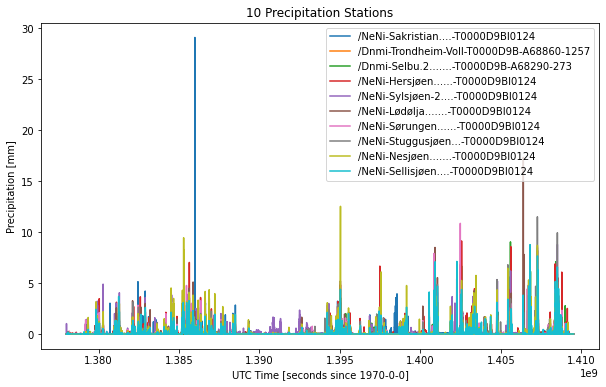

In [21]:
fig = plt.figure(figsize=(10, 6))

for i, name in enumerate(names):
    y = prec[:,i]
    plt.plot(nptime, y, label=name)


plt.title('10 Precipitation Stations')
plt.ylabel('Precipitation [mm]')
plt.xlabel('UTC Time [seconds since 1970-0-0]')
plt.legend()

### Create api.TimeSeries

Now, we have the data and time, or index value. Next we will create a Shyft object type, `shyft.api.TimeSeries`. To the uninitiated, this step may feel complex. In actuality it is a simple step and enables a great deal of underlying functionality within Shyft.







We'll extract the data from the netcdf file and work with the individual data series. 

**NOTE** the purpose here is to demonstrate the details, and is a **very inefficient** way to work. As stated previously, normally one would write their own repository to conduct all of this 'under the covers' using optimized python tools (e.g. xarray, numpy, etc.). The point here is that in the next steps, you can see how to work with individual data series that you may have read into python from, say for example, a *ahem* text file.


In [23]:
# we'll start by creating a time_axis:
# help(api.TimeAxis)
t = time[:]
# get the end time of the last interval as an integer:
end_t = int(2*t[-1] - t[-2])

# create a time_axis for the simulation
time_axis = sts.TimeAxis(sts.UtcTimeVector.from_numpy(t.astype(int)), end_t)
# here we used the call structure: __init__( (object)arg1, (UtcTimeVector)time_points, (int)t_end) -> None 
# creates a time-axis by specifying the time_points and t-end of the last interval


# next convert data time series into Shyft.api.TimeSeries objects:
p0 = sts.TimeSeries(time_axis, sts.DoubleVector.from_numpy(prec[:,0].flatten()), sts.POINT_AVERAGE_VALUE)


### Exploring the Shyft API
In the following section we'll explore several components of the `shyft.api`. We consider the strength of Shyft to lie within this Application Programming Interface, or API. To the uninitiated, it adds quite a degree of complexity. However, once you understand the different components and paradigms of Shyft, you'll see the flexibility the API offers provides a great number of possibilities for exploring hydrologic simulations.

The API approach will take a bit more code to get started, but will allow great flexibility later on. 

In [24]:
# get the simulator from yaml
from shyft.hydrology.orchestration.configuration.yaml_configs import YAMLSimConfig
from shyft.hydrology.orchestration.simulators.config_simulator import ConfigSimulator

config_file_path = os.path.join(shyft_data_path,"neanidelv/yaml_config/neanidelva_simulation.yaml")

cfg = YAMLSimConfig(config_file_path, "neanidelva")
simulator = ConfigSimulator(cfg) 
#
region_model = simulator.region_model
region_model_id = simulator.region_model_id
interpolation_id = simulator.interpolation_id
 

In the [first tutorial](run_nea_nidelva.ipynb#The-simulator-and-the-region_model) we discussed the `region_model`. If you are unfamiliar with this class, we recommend reviewing the [description](region_model.rst). 

#### The concept of Shyft repositories

In Shyft, we consider that input data is a "source". Our source data resides in some kind of data serialization... be it a text file, netcdf file, or database... One could have any kind of storage format for the source data. [Repositories](repositories.rst) are Python based interfaces to data. Several have been created within Shyft already, but users are encouraged to create their own. A guiding paradigm to Shyft is that data should live as close to the source as possible (ideally, at the source). The repositories connect to the data source and make the data available to Shyft.

In [25]:
# expose the repositories
region_model_repo = simulator.region_model_repository
interpolation_param_repo = simulator.ip_repos
geo_ts_repo = simulator.geo_ts_repository
initial_state_repo = simulator.initial_state_repo

Now we have exposed the **repositories** that we connected to our `region_model` during configuration. Having access to the repositories, means that we have access to the input data sources directly (found in `geo_ts_repository`). We also have several other repositories, including a repository for the interpolation parameters, initial state, and the region_model. We'll explore some of these a bit deeper now. But first we'll expose a few more pieces of information from the region_model while we're at it.

In [26]:
epsg = region_model.bounding_region.epsg()
bbox = region_model.bounding_region.bounding_polygon(epsg)
period = region_model.time_axis.total_period()
geo_ts_names = ("temperature", "wind_speed", "precipitation", "relative_humidity", "radiation")
sources = geo_ts_repo.get_timeseries(geo_ts_names, period, geo_location_criteria=bbox)

The `epsg` is simply the domain projection information for our simulation. `bbox` provides the bounding box coordinates. `period` gives the total period of the simulation. Lastly, we create a tuple of the 'geolocated timeseries names' or `geo_ts_names` as it is referred to here. And use this to get the *sources* out of our repository. Note that these names:

    temperature
    wind_speed
    precipitation
    relative_humidity
    radiation
    
Are embedded into Shyft as timeseries names that are required for simulations. In the current implementations, these are the default names used in repositories and, at present, the only forcing data required. If one were to develop new algorithms that reqiured other forcings, you would need to define these in a custom repository. See `interfaces.py` for more details.

Before going further, let's look at what we have so far...

We won't look in detail at all the repositories, but let's take a look at the `geo_ts_repo`:

In [27]:
# explore geo_ts_repo
#help(geo_ts_repo)

The `geo_ts_repo` is a collection of geolocated timeseries repositories. Note that `geo_ts_repo` has an attribute: `.geo_ts_repositories`... this seems redundant? This is simply a list of the repositories this class is 'managing'.

Maybe we want to look at the precipitation input series in more detail. We can get at those via this class. NOTE, this may not be the most typical way to look at your input data (presumably you may have already done this before the simulation working with the raw netcdf files), but in case you wish to see the datasets from the "model" perspective, this is how you gain access. Also, maybe you want to conduct a simulation, then make a data correction. You could do that by accessing the values here. Each of the aforementioned series types have a specialized source vector type in Shyft. In the case of precipitation it is a `api.PrecipitationSourceVector`. If we dig into this, we'll find some aspects familiar from the first tutorial.

Let's get the precipitation timeseries out of the repository for the period of the simulation first:

In [28]:
# above we already created a `sources` dictionary by
# using the `get_timeseries` method. This method takes a 
# list of the timeseries names as input and a period 
# of type 'shyft.api._api.UtcPeriod'
# it returns a dictionary, keyed by the names of the timeseries
prec = sources['precipitation']

# `prec` is now a `api.PrecipitationSourceVector` and if you look
# you'll see it 10 elements:
print(len(prec))


10


We can explore further and see each element is in itself an `api.PrecipitationSource`, which has a timeseries (ts). Recall from the [first tutorial](run_nea_nidelva.ipynb#Visualizing-the-discharge-for-each-[sub-]catchment) that we can easily convert the `timeseries.time_axis` into datetime values for plotting.

Let's plot the precip of each of the sources:

Text(0, 0.5, 'precip[mm/hr]')

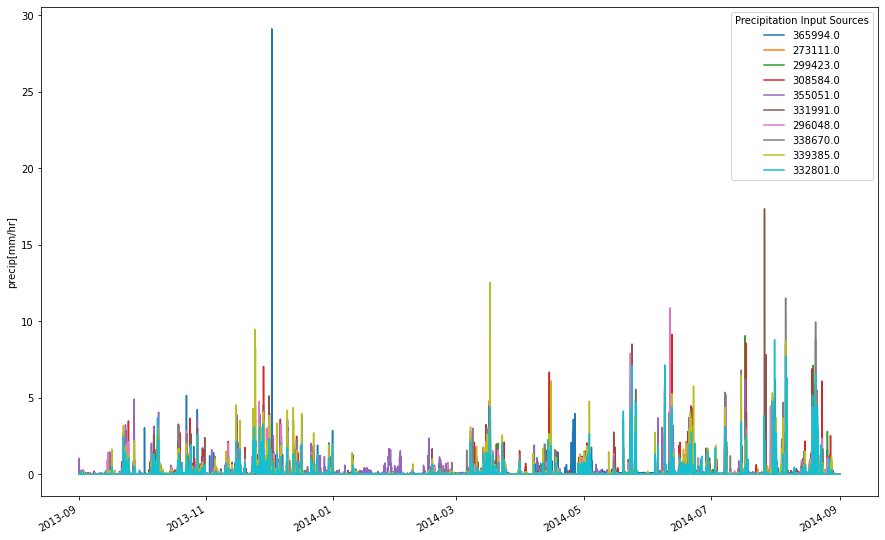

In [31]:
fig, ax = plt.subplots(figsize=(15,10))

for pr in prec:
    t,p = [dt.datetime.utcfromtimestamp(t_) for t_ in pr.ts.time_axis.time_points], pr.ts.values
    ax.plot(t[:-1],p, label=pr.mid_point().x) #uid is empty now, but we reserve for later use
fig.autofmt_xdate()
ax.legend(title="Precipitation Input Sources")
ax.set_ylabel("precip[mm/hr]")

Before we leave this section, we can also take a quick look at the `interpolation_param_repo`. This is a different type of repository, and it contains the parameters that will be passed to the interpolation algorithm to take a point-source timeseries and interpolate them to the Shyft cells, or in the context of of the API: `region_model.cells`. We'll quickly look at the `.params` attribute, which is a dictionary.

In [32]:
interpolation_param_repo.params

{'temperature': {'method': 'btk',
  'params': {'temperature_gradient': -0.6,
   'temperature_gradient_sd': 0.25,
   'nug': 0.5,
   'range': 200000.0,
   'sill': 25.0,
   'zscale': 20.0}},
 'precipitation': {'method': 'idw',
  'params': {'max_distance': 600000.0,
   'max_members': 10,
   'distance_measure_factor': 1,
   'scale_factor': 1.01}},
 'radiation': {'method': 'idw',
  'params': {'max_distance': 600000.0,
   'max_members': 10,
   'distance_measure_factor': 1.0}},
 'wind_speed': {'method': 'idw',
  'params': {'max_distance': 600000.0,
   'max_members': 10,
   'distance_measure_factor': 1.0}},
 'relative_humidity': {'method': 'idw',
  'params': {'max_distance': 600000.0,
   'max_members': 10,
   'distance_measure_factor': 1.0}}}

One quickly recognizes the same input source type keywords that are used as keys to the `params` dictionary. `params` is simply a dictionary of dictionaries which contains the parameters used by the interpolation model that is specific for each source type.

In closing, one is encouraged to understand well the concept of the **repositories**. As a user of Shyft, it is likely you'll want to create your own repository to access your data directly rather than creating input files for Shyft. Keep in mind that the repositories are Python code, and not a part of the core C++ code of Shyft. They are designed to provide an interface between the C++ code and potentially more 'pythonic' paradigms. In the following section, you'll see that we populate a C++ class from a repository collection.

#### The ARegionEnvironment class

The next thing we'll do is to create an `api.ARegionEnvironment` class to use in our custom simulation. As the `geo_ts_repo` was a Python interface that provided a collection of all the timeseries repositories, the `region_env` is an API type that provides a container of the "sources" of data specific to the model. We will now create an `api.ARegionEnvironment` from the `geo_ts_repo`. It may be helpful to think of a `region_env` as the container of input data for the  `region_model` -- in fact, that is what it is.

In [33]:
def get_region_env(sources_):
    region_env_ = api.ARegionEnvironment()
    region_env_.temperature = sources_["temperature"]
    region_env_.precipitation = sources_["precipitation"]
    region_env_.radiation = sources_["radiation"]
    region_env_.wind_speed = sources_["wind_speed"]
    region_env_.rel_hum = sources_["relative_humidity"]
    return region_env_

region_env = get_region_env(sources)

What we have done here is to convert our input data from the Python based repositories into a C++ type object that is used in the Shyft core. It may feel redundant to `geo_ts_repo`, but there are underlying differences. Still, you'll see that now the 'sources' are direct attributes of the `region_env` class:

In [34]:
print(len(region_env.precipitation))
type(region_env.precipitation[0])

10


shyft.hydrology._api.PrecipitationSource

#### Interpolation Parameters
In the same manner that we need to convert the sources from the Python based container, we'll also create an API object from the `interpolation_param_repo`.

In [35]:
interpolation_parameters = interpolation_param_repo.get_parameters(interpolation_id)

Okay, now we are set to *rebuild* our `region_model` from scratch. In the next few steps we're going to walk through initialization of the `region_model` to set it up for simulation.

### Initialization of the region_model
The two `shyft.api` types: `api.ARegionEnvironment` and `api.InterpolationParameter` together are used to initialize the `region_model`. In the next step, all of the timeseries input sources are interpolated to the geolocated model cells. After this step, each cell is the model has it's own `env_ts` which contains the timeseries for that cell. Let's first do the interpolation, the we can explore the `region_model.cells` a bit further.

In [36]:
#region_model.run_interpolation(interpolation_parameters, region_model.time_axis, region_env)
region_model.interpolate(interpolation_parameters, region_env)

True

Okay, that was simple. Let's look at the timeseries in some individual cells. The following is a bit of a contrived example, but it shows some aspects of the api. We'll plot the temperature series of all the cells in one sub-catchment, and color them by elevation.

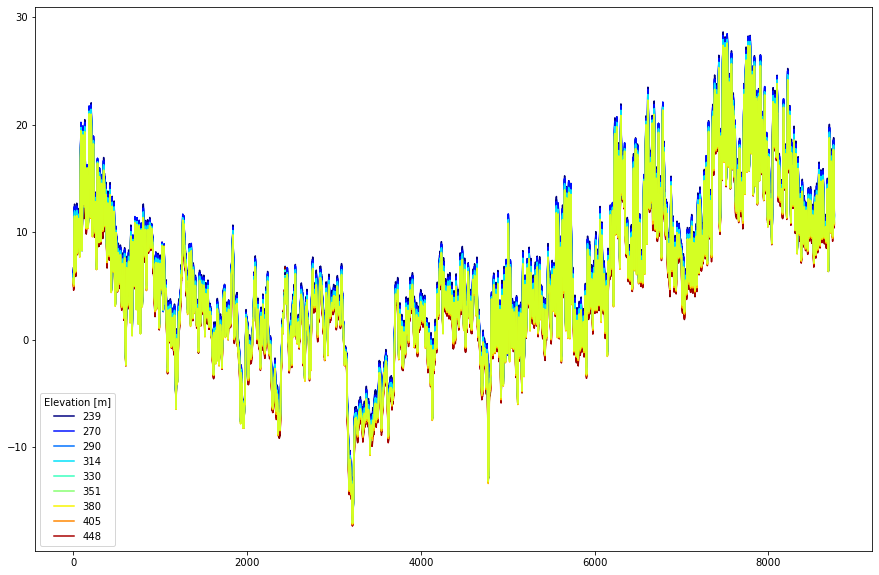

In [37]:
from matplotlib.cm import jet as jet
from matplotlib.colors import Normalize

# get all the cells for one sub-catchment with 'id' == 1228
c1228 = [c for c in region_model.cells if c.geo.catchment_id() == 1228]

# for plotting, create an mpl normalizer based on min,max elevation
elv = [c.geo.mid_point().z for c in c1228]
norm = Normalize(min(elv), max(elv))

#plot with line color a function of elevation
fig, ax = plt.subplots(figsize=(15,10))

# here we are cycling through each of the cells in c1228
for dat,elv in zip([c.env_ts.temperature.values for c in c1228], [c.mid_point().z for c in c1228]):
    ax.plot(dat, color=jet(norm(elv)), label=int(elv))
    
    
# the following is just to plot the legend entries and not related to Shyft
handles, labels = ax.get_legend_handles_labels()

# sort by labels
import operator
hl = sorted(zip(handles, labels),
            key=operator.itemgetter(1))
handles2, labels2 = zip(*hl)

# show legend, but only every fifth entry
ax.legend(handles2[::5], labels2[::5], title='Elevation [m]')

As we would expect from the temperature kriging method, we should find higher elevations have colder temperatures. As an exercise you could explore this relationship using a scatter plot.

Now we're going to create a function that will read initial states from the `initial_state_repo`. In practice, this is already done by the `ConfgiSimulator`, but to demonstrate lower level functions, we'll reset the states of our `region_model`:

In [38]:
# create a function to read the states from the state repository
def get_init_state_from_repo(initial_state_repo_, region_model_id_=None, timestamp=None):
    states = initial_state_repo_.find_state(
        region_model_id_criteria=region_model_id_,
        utc_timestamp_criteria=timestamp)
    if len(states) > 0:
        state_id = states[0].state_id  # most_recent_state i.e. <= start time
    else:
        raise Exception('No initial state matching criteria.')
    return initial_state_repo_.get_state(state_id)
 
init_state = get_init_state_from_repo(initial_state_repo, region_model_id_=region_model_id, timestamp=region_model.time_axis.start)

Don't worry too much about the function for now, but do take note of the `init_state` object that we created. This is another container, this time it is a class that contains `PTGSKStateWithId` objects, which are specific to the model stack implemented in the simulation (in this case `PTGSK`). If we explore an individual state object, we'll see `init_state` contains, for each cell in our simulation, the state variables for each 'method' of the method stack. The  .id of type CellStateId member ensures that the geographic personality of a saved state can be matched to the cells of the model that you now keep in memory (a safeguard).

Let's look more closely:

In [40]:
def print_pub_attr(obj):
    #only public attributes
    print(f'{obj.__class__.__name__}:\t',[attr for attr in dir(obj) if attr[0] != '_']) 
    
print(len(init_state))
init_state_cell0 = init_state[0] 
# the identifier
print_pub_attr(init_state_cell0.id)
# gam snow states
print_pub_attr(init_state_cell0.state.gs)

#init_state_cell0.kirchner states
print_pub_attr(init_state_cell0.state.kirchner)


3874
CellStateId:	 ['area', 'cid', 'x', 'y']
GammaSnowState:	 ['acc_melt', 'albedo', 'alpha', 'iso_pot_energy', 'lwc', 'sdc_melt_mean', 'surface_heat', 'temp_swe']
KirchnerState:	 ['q']


#### Summary
We have now explored the `region_model` and looked at how to instantiate a `region_model` by using a `api.ARegionEnvironment`, containing a collection of timeseries sources, and passing an `api.InterpolationParameter` class containing the parameters to use for the data interpolation algorithms. The interpolation step "populated" our cells with data from the point sources.

The cells each contain all the information related to the simulation (their own timeseries, `env_ts`; their own model parameters, `parameter`; and other attributes and methods). In future tutorials we'll work with the cells indivdual "resource collector" (`.rc`) and "state collector" (`.sc`) attributes.



